# Practical Data Science Report - 2
### John 'Eoin' Cronin-McCartney

Student no: 20221758


## Semantic Search Engine
### An exploration of semantic similarity in multiple languages

I believe that Question-Answer systems designed to facilitate knowledge seeking should be able to retrieve across language barriers, users should not have to learn a new language before being able to pursue their professional, academic or personal information needs. In order to utilise information from languages we can train QA systems with multiple languages.
My goal is to develop a system that can retrieve data cross-lingually [1] that is data which can answer questions posed in one language, language A, where the information is found in another, language B.

Datasets with multiple languages are key to my research, one of the most interesting and important developments in machine learning and data science in multilingual research has been the development of language agnostic embeddings[2].<br><br>
Language agnostic embeddings create a dense representation of a sentence or question in one of multiple languages and embed them into a shared space.<br>

The development of these embeddings forms the basis of research into multi and cross-lingual question answering by projecting sentences and queries from multiple languages into a semantically similar space.

I want to create a set of functions that can be used to search queries in a database to find semantically similar results regardless of the language they are written in.
In this assignment I explore a dataset, tydi QA [3] I have previously worked with in order to further understand how multilingual datasets can be manipulated.

## Pre-Processing
Imports and data check

In [1]:
import numpy as np
import faiss
import requests
from io import StringIO
import pandas as pd
from datasets import load_dataset

In [2]:
ds_tydi =  load_dataset('tydiqa','primary_task')

Reusing dataset tydiqa (/Users/johncmcc/.cache/huggingface/datasets/tydiqa/primary_task/1.0.0/b8a6c4c0db10bf5703d7b36645e5dbae821b8c0e902dac9daeecd459a8337148)
100%|██████████| 2/2 [00:00<00:00,  6.69it/s]


In [3]:
df_val = ds_tydi['validation'].to_pandas()
df_val.head()

,passage_answer_candidates,question_text,document_title,language,annotations,document_plaintext,document_url
0,"{'plaintext_start_byte': [1, 517, 1805, 2966, ...",หม่อมราชวงศ์สุขุมพันธุ์ บริพัตร เรียนจบจากที่ไ...,หม่อมราชวงศ์สุขุมพันธุ์ บริพัตร,thai,"{'passage_answer_candidate_index': [-1, -1, -1...",\nรองศาสตราจารย์[1] หม่อมราชวงศ์สุขุมพันธุ์ บร...,https://th.wikipedia.org/wiki/%E0%B8%AB%E0%B8%...
1,"{'plaintext_start_byte': [1, 280, 468, 812], '...",Ukubwa wa Rijili Kantori ni kiasi gani?,Rijili Kantori,swahili,"{'passage_answer_candidate_index': [-1, -1, -1...","\nRijili Kantori , Rijili Kantarusi au ing. Al...",https://sw.wikipedia.org/wiki/Rijili%20Kantori
2,"{'plaintext_start_byte': [1, 1124, 2274, 2571,...",అలి గౌహర్ ఎన్ని సంవత్సరాలు జీవించాడు?,అహమ్మద్ షా బహదూర్,telugu,"{'passage_answer_candidate_index': [27, -1, -1...","\nఅహమ్మద్ షా బహదూర్, మిర్జా అహమ్మద్ షా, షహన్‌ష...",https://te.wikipedia.org/wiki/%E0%B0%85%E0%B0%...
3,"{'plaintext_start_byte': [0, 351, 553, 1244, 1...",Milloin Kokemäki on perustettu?,Kokemäki,finnish,"{'passage_answer_candidate_index': [-1, 16, -1...","\nKokemäki () on Suomen kaupunki, joka sijaits...",https://fi.wikipedia.org/wiki/Kokem%C3%A4ki
4,"{'plaintext_start_byte': [1, 1091, 2520, 3062,...",১৯৮১ সালে বাংলাদেশের সেনাবাহিনীর সেনাপ্রধান কে...,হুসেইন মুহাম্মদ এরশাদ,bengali,"{'passage_answer_candidate_index': [-1, -1, -1...","\nহুসেইন মুহাম্মদ এরশাদ (ফেব্রুয়ারি ১, ১৯৩০) ...",https://bn.wikipedia.org/wiki/%E0%A6%B9%E0%A7%...


### Embedding Queries
I Take all queries from the dataset and use a pre-trained multilingual model to embed them into a shared space.

In [4]:
sentences = df_val['question_text'].tolist()
sentences[:5]

['หม่อมราชวงศ์สุขุมพันธุ์ บริพัตร เรียนจบจากที่ไหน ?',
 'Ukubwa wa Rijili Kantori ni kiasi gani?',
 'అలి గౌహర్ ఎన్ని సంవత్సరాలు జీవించాడు?',
 'Milloin Kokemäki on perustettu?',
 '১৯৮১ সালে বাংলাদেশের সেনাবাহিনীর সেনাপ্রধান কে ছিলেন ?']

Storing back-up of data outside of volatile memory

In [5]:
with open('sentences.txt', 'w') as fp:
    fp.write('\n'.join(sentences))

Now the sentences can be embedded.<br>
I wish to have the sentences be represented language agnostic so that they are grouped by meaning rather than by language.
I want to find the semantic similarity between models.


There are a number of different pre-trained models which can be used for this task which reduces the need for long training epochs.
I have decided to use a pre-trained multilingual model which embeds based on semantic similarity from huggingface

In [8]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('distiluse-base-multilingual-cased-v2')

In [9]:
sentence_embeddings = model.encode([x for x in sentences])
sentence_embeddings.shape

(18670, 512)

If needed the file can be saved and loaded for use without re-initialising the embeddings

In [10]:
with open(f'./data/embeddings_X.npy', 'wb') as fp:
    np.save(fp, sentence_embeddings[0:256])

In [11]:
split = 1024
file_count = 0
for i in range(0, sentence_embeddings.shape[0], split):
    end = i + split
    if end > sentence_embeddings.shape[0] + 1:
        end = sentence_embeddings.shape[0] + 1
    num = str(file_count)
    with open(f'./data/embeddings_{num}.npy', 'wb') as fp:
        np.save(fp, sentence_embeddings[i:end, :])
    print(f"embeddings_{num}.npy | {i} -> {end}")
    file_count += 1

embeddings_0.npy | 0 -> 1024
embeddings_1.npy | 1024 -> 2048
embeddings_2.npy | 2048 -> 3072
embeddings_3.npy | 3072 -> 4096
embeddings_4.npy | 4096 -> 5120
embeddings_5.npy | 5120 -> 6144
embeddings_6.npy | 6144 -> 7168
embeddings_7.npy | 7168 -> 8192
embeddings_8.npy | 8192 -> 9216
embeddings_9.npy | 9216 -> 10240
embeddings_10.npy | 10240 -> 11264
embeddings_11.npy | 11264 -> 12288
embeddings_12.npy | 12288 -> 13312
embeddings_13.npy | 13312 -> 14336
embeddings_14.npy | 14336 -> 15360
embeddings_15.npy | 15360 -> 16384
embeddings_16.npy | 16384 -> 17408
embeddings_17.npy | 17408 -> 18432
embeddings_18.npy | 18432 -> 18671


## Semantic Similarity

I want to check that the questions in the data set are organised by semantic similarity rather than by language.<br>
Similarity in Sentence Embeddings can be thought of as the distance between 2 vectors.

There are a number of ways to calculate the distance between 2 vectors, I will use the Cosine Similarity to compute the distance.

### Cosine Similarity

The cosine similarity measures distance between 2-vectors by computing the angle between the 2 vectors.
It takes the cosine of the angle between 2 vectors in a multidimensional space given by: 

$$
\operatorname{similarity}(x, y)=\cos (\theta)=\frac{x \cdot y}{|x||y|}
$$

This essentially take the dot-product of 2 vectors `x` & `y` and divides this by the product of the length of `x` & `y`
Math libraries commonly give the cosine similarity as a built in function and so we can use the sklearn implementation to calculate the similarity between our two vectors.

In [12]:
from sklearn.metrics.pairwise import cosine_similarity 
# Calculating the Cosine distance between all pairs of embedded sentences

# put embeddings in matrix
embed_mat = np.array([x for x in sentence_embeddings])
# calculate distance between every embedding pair 
sim_mat = cosine_similarity(embed_mat,embed_mat)

def compare(sen_comp, embeddings):
  # write sim scores to df  
  df_val['sim_score'] = sim_mat[sen_comp]
  return df_val

# Choose a sentence, 35 is hand chosen at random
sen_comp=35
sim_sen = compare(sen_comp,sentence_embeddings)

### Expectation of Similarity

For the vectors to have been encoded based on their semantic similarity rather than their linguistic similarity we would expect to see the closest vectors to the selected vector be chosen independently of language.<br>
Below we can see a variety of languages amongst the top 10 which is a good indication that we have encoded our vectors semantically.

In [13]:
print("Similarities for Sentence : " + df_val.iloc[sen_comp].question_text)
sim_sen[{'question_text','sim_score','language'}].sort_values('sim_score', ascending=False)[0:10]

Similarities for Sentence : Voiko historiaa opiskella Kuopiossa?


,sim_score,question_text,language
35,1.000000,Voiko historiaa opiskella Kuopiossa?,finnish
10132,0.606740,Voiko keramiikkaa opiskella Suomessa?,finnish
16890,0.572717,孟子を題材とした日本の歴史小説はありますか？,japanese
15181,0.570124,若松城の中を見学することはできる？,japanese
14551,0.545060,Voiko työnjohtoa opiskella?,finnish
11620,0.544570,هل تدرس باكلوريوس الرياضة في ‫جَامِعَةُ العُلو...,arabic
1999,0.540544,북학파를 중상학파라고도 하나요?,korean
8757,0.538410,Onko Hesekielin temppeli historiallinen kohde?,finnish
28,0.537090,Voiko Oulussa opiskella lakimieheksi?,finnish
4108,0.527801,Dodoma iko na ukubwa gani ya kijiographia?,swahili


The above sentences show a variety of languages the first line is the chosen

### Similarity of First 100 Sentences

We can generate a matrix to store the cosine similarities between each sentence in our embeddings.<br>
This can be an interesting way to view the variation across our dataset at a quick glance by using a heatmap.<br>
A heatmap with a very `light` overall colour would indicate that much our data is very similar in nature whereas a `dark` coloured heatmap would indicate that our samples are semantically very far apart.<br><br>
Plotting the first 100 values as a heatmap will give a snapshot of the variety that the dataset has. A darker overall colour with strong variance indicates a useful dataset where many sentences are semantically different with some having similar semantic meaning.

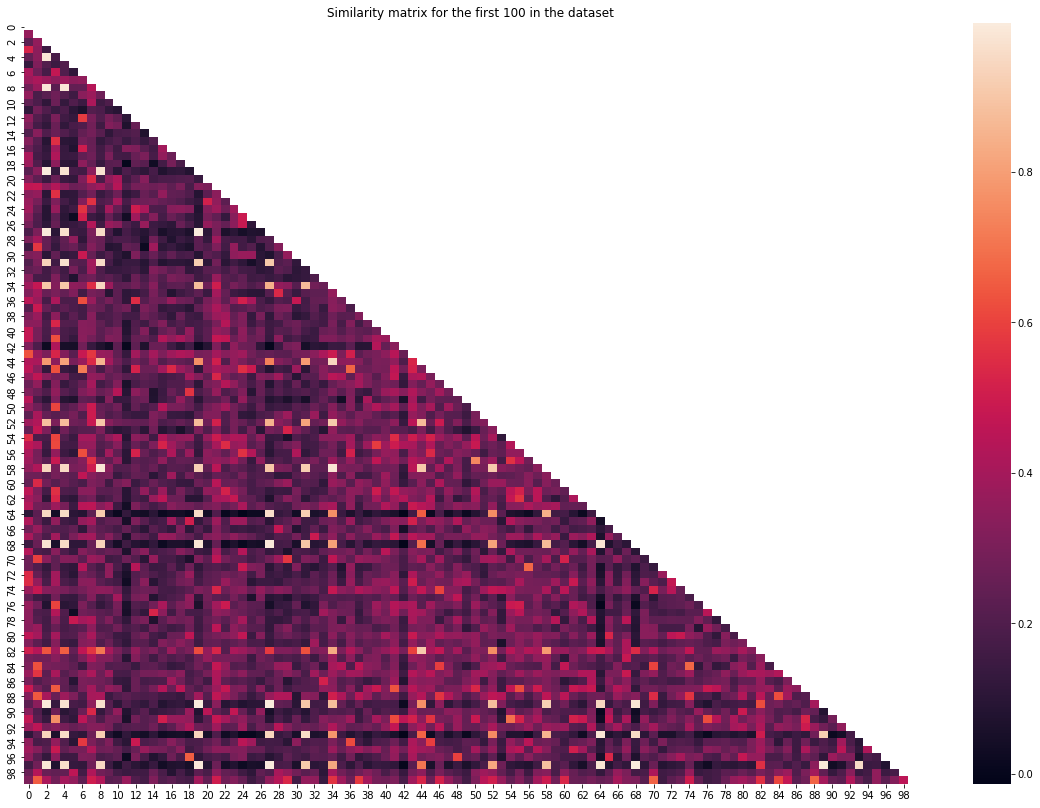

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot HeatMap
def plot_heatmap():
  # Plot heatmap for the first 100 sentences
  mask = np.zeros_like(sim_mat[:100, :100])
  mask[np.triu_indices_from(mask)] = True
  fig, ax = plt.subplots(figsize=(20,14)) 
  ax = sns.heatmap(sim_mat[:100, :100],mask=mask)

  ax.axes.set_title(f"Similarity matrix for the first 100 in the dataset",)

plot_heatmap()

## Topic Exploration
We can check if we have sentences related to specific topics by formulating sentences in English and searching for semantically similar sentences.<br><br>
To do this I will need to make up some questions so that I can check for semantic similarity.
I will use the following questions and note my expectations:
- 'Who was the actor in'
     - Questions related to Movies or Cinema
- 'How high is the peak of mount Fuji' 
    - Questions related to size, mountains or geographic features

K-nearest neighbour technique can be used to find the nearest related questions to each question. <br>

In [15]:
t_questions = ["Who was the actor in","How high is the peak of mount Fuji"]
questions = model.encode(t_questions)

In [16]:
def compare_new_sen(new_sen):
  # Replicate embedding for input string 
  m = np.array([new_sen,]*len(df_val))
  emb_sim = cosine_similarity(new_sen.reshape(1,-1),embed_mat)
  #write sim score
  return emb_sim[0]

for i in range(0,len(questions)):
  df_val['sim_score_{}'.format(i)] = compare_new_sen(questions[i])

#### Check in English
Checking that our queries have been encoded correctly and will return related results in English provides a sanity check for the functions used to generate the scores.</br>
Our ability to match related sentences within the source language provides evidence that our algorithms are working in an attended way in a limited space. We can then confidently expand the search space to use the full multilingual setting.

#### K-nearest Neighbour
I employ a k-nearest neighbour technique where I simply retrieve those embeddings closest in distance between my newly embedded query vector and the sentence embeddings generated by the model.
I have chosen `k = 5`.<br>

The distance is calculated using semantic similarity with the higher values closest in relation

In [17]:
df_list = {}

for i in range(0,len(questions)): 
  print("Similarities for English Sentences : " + t_questions[i])
  score_col = "sim_score_{}".format(i)
  df_list[i] = df_val[{'question_text',score_col,'language'}].sort_values(score_col, ascending=False).loc[df_val["language"] == 'english'][:5]
  df_list[i]["query"] = [t_questions[i]] * 5
  df_list[i].rename(columns={score_col : "sim_score"}, inplace=True)
  display(df_list[i])

Similarities for English Sentences : Who was the actor in


,sim_score,question_text,language,query
10968,0.624705,Who is considered a celebrity?,english,Who was the actor in
16440,0.623977,Who was the lead actress on Guiding Light?,english,Who was the actor in
11467,0.567858,Who invented the motion picture?,english,Who was the actor in
9257,0.552982,Who was the first director of the CIA?,english,Who was the actor in
11425,0.538319,Who is the main character in Bleach?,english,Who was the actor in


Similarities for English Sentences : How high is the peak of mount Fuji


,language,question_text,sim_score,query
1789,english,How high is the highest point in The Alps?,0.659185,How high is the peak of mount Fuji
9903,english,What is the tallest mountain in the Allegheny ...,0.566455,How high is the peak of mount Fuji
9644,english,What is the largest volcanic mountain?,0.526792,How high is the peak of mount Fuji
13804,english,What is the elevation of Bogota?,0.517400,How high is the peak of mount Fuji
17839,english,What is the largest recorded tsunami?,0.392555,How high is the peak of mount Fuji


We can see from the results for both of our queries that we are retrieving sentences that are considerably close semantically to our query sentences.</br>
The results from the first query returns questions related to celebrities or people of note with a strong connection to cinema and TV shows.<br>

The second set of results, references mountain ranges while not specifying a single mountain as in our query, it also returns queries related to geographical features.<br>
<br>It is important to note that the distance between the second set of vectors and its query is on average lower than in the first set of results.<br> This indicates that they are less strongly related than those in the first set of results explaining why they are not as similar as our first set. <br>We can compare the distance in a bar chart.


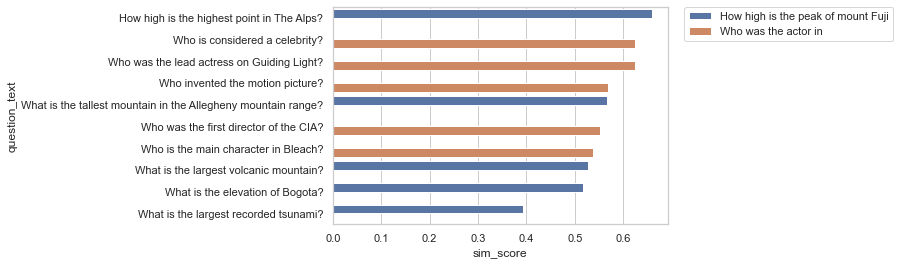

In [18]:
# Place all data in single dataframe for plotting, update index maintain order of similarity
df_query_comp = pd.concat(df_list, ignore_index=True).sort_values("sim_score", ascending=False)

sns.set_theme(style="whitegrid")
ax = sns.barplot(x="sim_score", y="question_text", data=df_query_comp, hue="query")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

plt.show()

We can easily see the difference between the datasets semantic results for each query and can now perform similar comparisons for multilingual data.

In [19]:
# Again perform KNN without limiting to english data
df_mlist = {}
for i in range(0,len(questions)): 
  print("Similarities for All Sentences : " + t_questions[i])
  score_col = "sim_score_{}".format(i)
  df_mlist[i] = df_val[{'question_text',score_col,'language'}].sort_values(score_col, ascending=False)[:5]
  df_mlist[i]["query"] = [t_questions[i]] * 5
  df_mlist[i].rename(columns={score_col : "sim_score"}, inplace=True)
  display(df_mlist[i])

Similarities for All Sentences : Who was the actor in


,sim_score,question_text,language,query
10788,0.740267,siapakah sutradara film merantau?,indonesian,Who was the actor in
10681,0.725935,ใครเป็นผู้แสดงนำในเรื่อง มาสค์ไรเดอร์ไฟซ์?,thai,Who was the actor in
1959,0.715274,Siapa pemeran utama film Fences ?,indonesian,Who was the actor in
15085,0.703290,Siapakah karakter utama dalam film Fiksi ?,indonesian,Who was the actor in
2654,0.695845,Siapakah yang menjadi tokoh utama dalam film I...,indonesian,Who was the actor in


Similarities for All Sentences : How high is the peak of mount Fuji


,language,question_text,sim_score,query
1789,english,How high is the highest point in The Alps?,0.659185,How high is the peak of mount Fuji
3669,finnish,Kuinka korkea on Kalliovuorten korkein huippu?,0.649783,How high is the peak of mount Fuji
18610,japanese,六甲山の頂上の標高は？,0.638958,How high is the peak of mount Fuji
2940,thai,ฟีลีปี โกชิญญู โกเรย์ยา สูงเท่าไหร่?,0.593880,How high is the peak of mount Fuji
16657,arabic,ما هو ارتفاع سد وادي نجران؟,0.584638,How high is the peak of mount Fuji


In [20]:
df_mquery_comp = pd.concat(df_mlist, ignore_index=True).sort_values("sim_score", ascending=False)
df_mquery_comp

,sim_score,question_text,language,query
0,0.740267,siapakah sutradara film merantau?,indonesian,Who was the actor in
1,0.725935,ใครเป็นผู้แสดงนำในเรื่อง มาสค์ไรเดอร์ไฟซ์?,thai,Who was the actor in
2,0.715274,Siapa pemeran utama film Fences ?,indonesian,Who was the actor in
3,0.703290,Siapakah karakter utama dalam film Fiksi ?,indonesian,Who was the actor in
4,0.695845,Siapakah yang menjadi tokoh utama dalam film I...,indonesian,Who was the actor in
5,0.659185,How high is the highest point in The Alps?,english,How high is the peak of mount Fuji
6,0.649783,Kuinka korkea on Kalliovuorten korkein huippu?,finnish,How high is the peak of mount Fuji
7,0.638958,六甲山の頂上の標高は？,japanese,How high is the peak of mount Fuji
8,0.593880,ฟีลีปี โกชิญญู โกเรย์ยา สูงเท่าไหร่?,thai,How high is the peak of mount Fuji
9,0.584638,ما هو ارتفاع سد وادي نجران؟,arabic,How high is the peak of mount Fuji


#### Multilingual Display

Unfortunately MatPlotLib and derivative libraries such as Seaborn do not support multiple fonts without significant workarounds that I found unsuitable for displaying the different languages in this diagram. [See issue raised here](https://github.com/matplotlib/matplotlib/issues/15260)

I performed an exhaustive search of all available fonts in the `MatPlotLib Font Manager` and displayed a set of characters from each relevant language of strings.

In [ ]:
# This was used to discover which font can display all characters
# Takes some time to run and displays hundreds of fonts
# 
import matplotlib as mpl
fonts = set([f.name for f in mpl.font_manager.fontManager.ttflist])

# Set up plots
plt.figure(figsize=(10,len(fonts)/4))
 
# Plot each font render beside font name
for i, font in enumerate(fonts):
    plt.text(0, i, f"日本語  ฟีลีปี نجران：{font}", fontname=font)
    
plt.ylim(0, len(fonts))
plt.axis("off")

plt.show()
# Arial Unicode MS shown to be only font capable of rendering all 3

Here is a sample of the plotted output from the above function including the correctly identified font

![](Fonts.png)

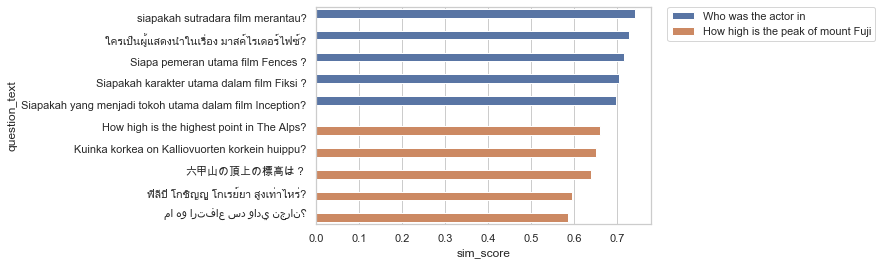

In [21]:
sns.set_theme(style="whitegrid")
plt.rcParams['font.family'] = ['Arial Unicode MS']
ax = sns.barplot(x="sim_score", y="question_text", data=df_mquery_comp, hue="query")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

plt.show()

## Results and Conclusion

It is clear that we are able to return strings in other languages with high similarity scores.</br>
The most similar string to our first query `siapakah sutradara film merantau?` is Indonesian for `who is the director of the film merantau?`. This is clearly strongly related to our initial query both in subject and structure. [4]<br>
Likewise the highest similarity score for the second query has returned semantically very similar text with a query very close to the original query given a high similarity score.<br>

Although I personally find the top result relating to the `mount Fuji` query to be much more similar, this is one of the trade-offs that must come when dealing with multiple languages.<br>
Semantics varies across peoples and languages this is reflected when encoding translated data.<br>

This does however demonstrate that our semantic search works and will allow the exploration of multilingual data when training question answering models.
The importance of semantic relations are apparent when considering what a trained QA system scores well on and what it scores poorly on.<br>
If a trained model is unable to answer a question in French about a well known mountain in Japan we can identify potential gaps in its knowledge by finding questions related to the geography of Japan or questions about mountains in other places.<br>
These questions will contain similar topics while likely being in different languages.<br> 
Once identified and tested the results will allow me to understand if the difficulty is related to the language of the query or the topic of the query in greater detail.

### Sources:
1. Asai, A., Yu, X., Kasai, J., & Hajishirzi, H. (2021). One question answering model for many languages with cross-lingual dense passage retrieval. Advances in Neural Information Processing Systems, 34.
2. Yang, Y., Cer, D., Ahmad, A., Guo, M., Law, J., Constant, N., ... & Kurzweil, R. (2019). Multilingual universal sentence encoder for semantic retrieval. arXiv preprint arXiv:1907.04307.
3. Clark, J. H., Choi, E., Collins, M., Garrette, D., Kwiatkowski, T., Nikolaev, V., & Palomaki, J. (2020). TyDi QA: A benchmark for information-seeking question answering in typologically diverse languages. Transactions of the Association for Computational Linguistics, 8, 454-470.
4. DeepL Translate: The world’s most accurate translator. (n.d.). DeepL. Retrieved August 2, 2022, from http://www.deepl.com/translator